### Exercise 6.3

Download the flow around the cylinder data. Using the first $P\%$ of the temporal snapshots, forecast the remaining $(100-P)\%$ future state data. Do this by training a neural network on the high-dimensional data.

(i) using a feedforward neural network.

Determine the performance of the algorithms as a function of decreasing data $P$.

Redo the forecasting calculations by training a model in the reduced subspace $U$ from the singular value decomposion. 

Evaluate the forecasting performance as a function of the percentage of the training data $P$ and the rank of the reduced space $r$.

In [2]:
import scipy.io  # io: imput and output
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

In [3]:
# Load the data set for fluid past a cylinder
mat_contents = scipy.io.loadmat(os.path.join('..','Data','CYLINDER_ALL.mat'))

In [ ]:
# mat_contents.keys()

In [4]:
vortall = mat_contents['VORTALL']  # multiple vorticity field snapshots

In [5]:
vortall.shape

(89351, 151)

In [6]:
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nt = vortall.shape[1]

In [7]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from numpy import hstack 
from sklearn.metrics import mean_squared_error

In [8]:
def create_dataset(dataset, time_step=1):
  data_X, data_Y = [], []
  for i in range(dataset.shape[1]-time_step-1):
    a = dataset[:, i:(i+time_step)]   
    data_X.append(a)
    data_Y.append(dataset[:, i+time_step])
  return np.array(data_X), np.array(data_Y)

In [8]:
def ffnn_mse(data2d, p, time_step):
    
    last_index = int(nt*p)
    train = data2d[:,:last_index]
    test  = data2d[:,last_index:]
    
    X_train, y_train = create_dataset(train, time_step)
    X_test,   y_test = create_dataset(test,  time_step)
    
    n_input  = X_train.shape[1]*X_train.shape[2]
    n_output = y_train.shape[1]*1

    X_train = X_train.reshape((X_train.shape[0], n_input))
    X_test  =  X_test.reshape(( X_test.shape[0], n_input))

    # define model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=n_input))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse',metrics=["accuracy"])

    # fit model
    model.fit(X_train, y_train, epochs=100, verbose=0)
    
    # prediction
    test_predict = model.predict(X_test)
    test_predict.shape, y_test.shape
    
    mse = mean_squared_error(y_test, test_predict, squared = False) 
    
    return mse

In [9]:
p = np.arange(0.1, 1, 0.1)
time_step = 5

In [10]:
mse = []

for i in range(len(p)):
    mse.append( ffnn_mse(vortall, p[i], time_step) )

1/1 [==============================] - 0s 48ms/step


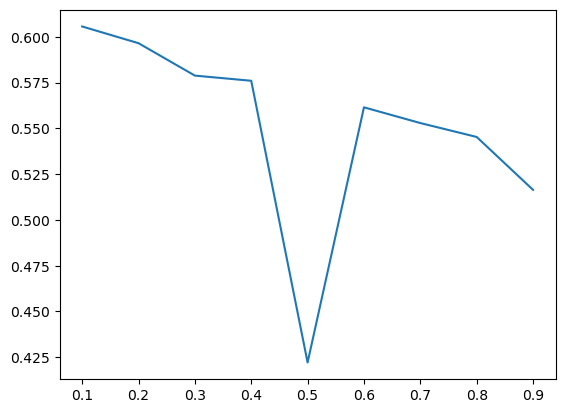

In [11]:
plt.plot(p, mse)
plt.show()

(iii) using an RNN. (bonus)

In [9]:
from keras.layers import SimpleRNN, Dense

In [10]:
def rnn_mse(data2d, p, time_step):
    
    last_index = int(nt*p)
    train = data2d[:,:last_index]
    test  = data2d[:,last_index:]
    
    train = vortall[:,:last_index]
    test  = vortall[:,last_index:]
    
    X_train, y_train = create_dataset(train, time_step)
    X_test,   y_test = create_dataset(test,  time_step)

    y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1])
    y_test  =  y_test.reshape( y_test.shape[0]* y_test.shape[1])

    X_train = X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2], 1))
    X_test  =  X_test.reshape(( X_test.shape[0]* X_test.shape[1],  X_test.shape[2], 1))

    # define model
    model = Sequential([SimpleRNN(20, return_sequences = True, input_shape = [None,1]),
                        SimpleRNN(20, return_sequences = True),
                        SimpleRNN(20),
                        Dense(1)])
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    # fit model
    model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50, verbose=0)    
    
    # prediction
    test_predict = model.predict(X_test)
    mean_squared_error(y_test,test_predict, squared = False) 
    
    return mse

In [11]:
p = np.arange(0.1, 1, 0.1)
time_step = 5

In [ ]:
mse = []

for i in range(len(p)):
    mse.append( rnn_mse(vortall, p[i], time_step) )

362989/362989 [==============================] - 347s 955us/step


In [ ]:
plt.plot(p, mse)
plt.show()